## TO TEST NEW CODE

In [1]:
import os
import skimage
import astropy

# Aliases
import numpy as np
import matplotlib.pyplot as plt

from cartesian_to_polar import CartesianToPolar

In [2]:
# Import the images

path = os.path.join(os.getcwd(), '..', '..', 'sdo')
filepath = os.path.join(path, 'AIA_fullhead_000.fits.gz')
hdul = astropy.io.fits.open(filepath)

In [ ]:
new_polar = CartesianToPolar.get_polar_image(
    image_nb=1,
    output_shape=(1_000, 1_000),
    borders= {
        'radial distance': (690, 870),
        'polar angle': (245, 295),
    },
    direction='clockwise',
    theta_offset=90,
    channel_axis=None,
)

dx is 442182.9358540857
the max index is 667.1446952836415
_coord: max of image is 1.0
_coord0: max of image is 0.0
_coord1: max of image is 0.0
_coord2: max of image is 0.0


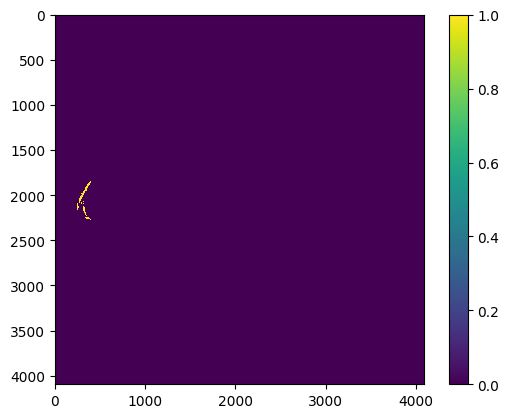

In [3]:
image = hdul[0].data

plt.figure()
plt.imshow(image, interpolation='none')
plt.colorbar()
plt.show()

In [4]:
header = hdul[0].header
header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                   64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 4096                                                  
NAXIS2  =                 4096                                                  
BLD_VERS= 'V6R3X'                                                               
LVL_NUM = 1.000000                                                              
T_REC   = '2012-07-23T00:06:45Z'                                                
TRECSTEP= 1.000000                                                              
TRECEPOC= '1977.01.01_00:00:00_TAI'                                             
TRECROUN=                    1                                                  
ORIGIN  = 'SDO/JSOC-SDP'                                                        
DATE    = '2012-12-07T20:54:

In [5]:
# Image to polar
rsun_image = header
image_polar = skimage.transform.warp_polar(
    image,
    center=(header['X0_MP'], header['Y0_MP']),
    output_shape=(4096, 4096),
    
) #TODO: add radius later

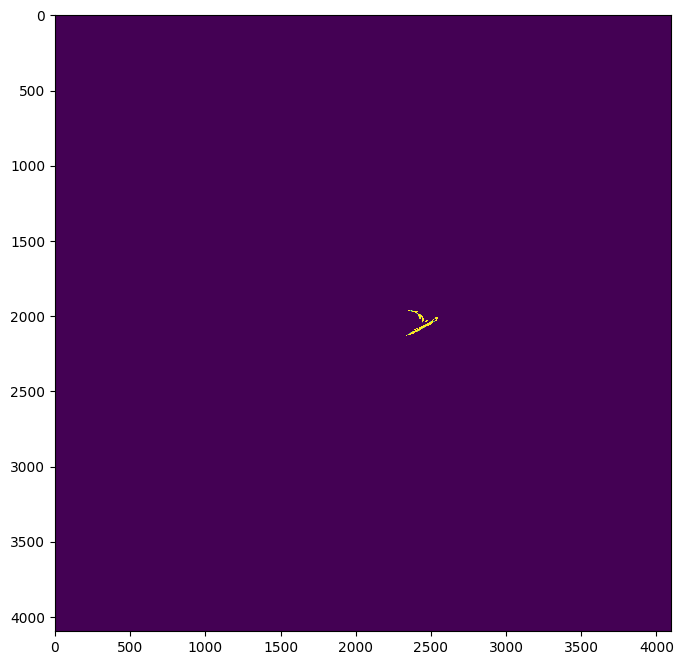

In [6]:
plt.figure(figsize=(14, 8))
plt.imshow(image_polar, interpolation='none')
# plt.xlim(1600, 1900)
# plt.ylim(140, 220)
plt.show()

_coord: max of image is 1.0
_coord0: max of image is 0.0
_coord1: max of image is 0.0
_coord2: max of image is 0.0


In [16]:
np.min(new_polar)

np.float64(0.0)

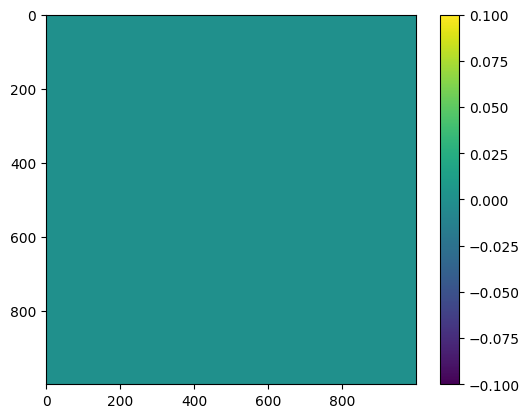

In [13]:
plt.figure()
plt.imshow(new_polar, interpolation='none')
plt.colorbar()
plt.show()

X0_MP: Master pointing X0 sun center in CCD frame in pixels, start 0.0 (float) for raw image. so the first pixel is labeled as 0?
columns is the x axis. so plt.plot(x, y) should be in the right order I think.

other import keys might be CDELT, RSUN_REF, RSUN_OBS,
Do I need SAT_ROT?

In [8]:
# Try and get the d_theta for each pixel
def get_d_theta(image: np.ndarray) -> float:

    theta_length = image.shape[1]
    print(f'theta length is {theta_length}')

    d_theta = 360 / theta_length
    print(f'd_theta is {d_theta}')
    return d_theta

In [10]:
d_theta = get_d_theta(image_polar)

theta length is 4096
d_theta is 0.087890625


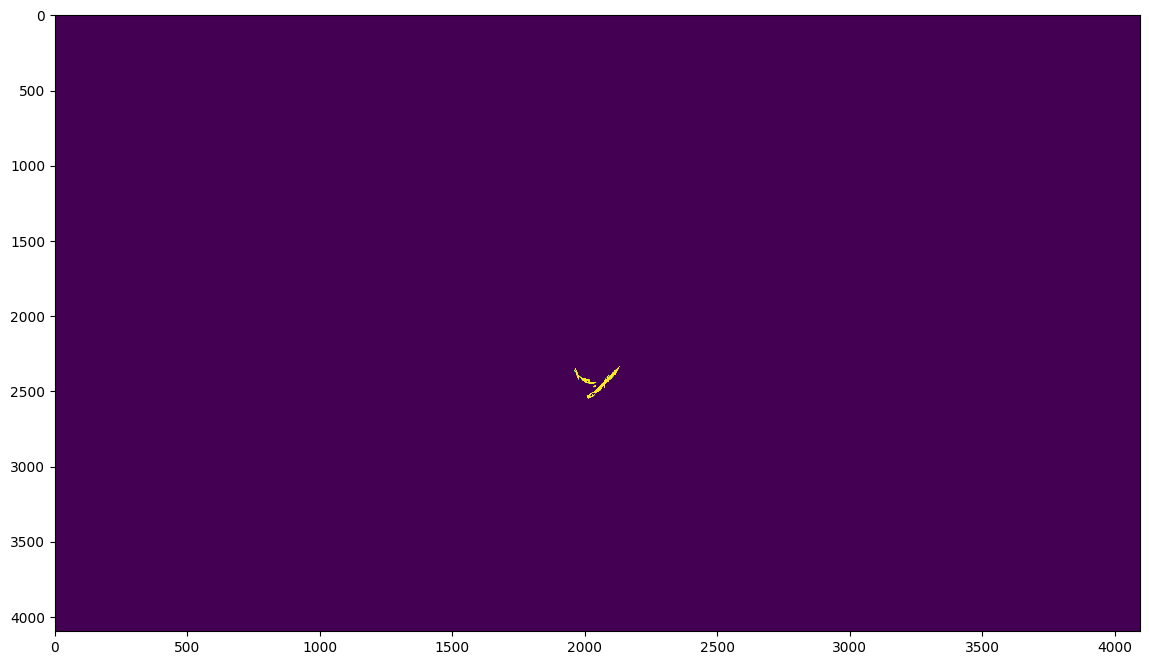

In [32]:
plt.figure(figsize=(14, 8))
plt.imshow(image_polar.T, interpolation='none', aspect='auto')
# plt.xlim(245 / d_theta, 295 / d_theta)
# plt.ylim(140, 220)
plt.show()

In [ ]:
def cartesian_to_polar(
        image: np.ndarray,
        center: tuple[int | float, int | float],
        direction: str,
    ) -> dict[str, np.ndarray]:
    
    x, y = np.nonzero(image)
    x_0, y_0 = center

    radial_distance = np.sqrt((x - x_0)**2 + (y - y_0)**2)
    polar_angle = np.arctan2(y - y_0, x - x_0)

    polar_coordinates = {
        'radial distance': radial_distance,
        'polar angle': (polar_angle + np.pi) * 180 / np.pi,
    }
    return polar_coordinates



x: [ 0 10 20 30 40 50 60 70 80 90  0 10 20 30 40 50 60 70 80 90  0 10 20 30
 40 50 60 70 80 90  0 10 20 30 40 50 60 70 80 90  0 10 20 30 40 50 60 70
 80 90  0 10 20 30 40 50 60 70 80 90  0 10 20 30 40 50 60 70 80 90  0 10
 20 30 40 50 60 70 80 90  0 10 20 30 40 50 60 70 80 90  0 10 20 30 40 50
 60 70 80 90]
y: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7
 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9]
values: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


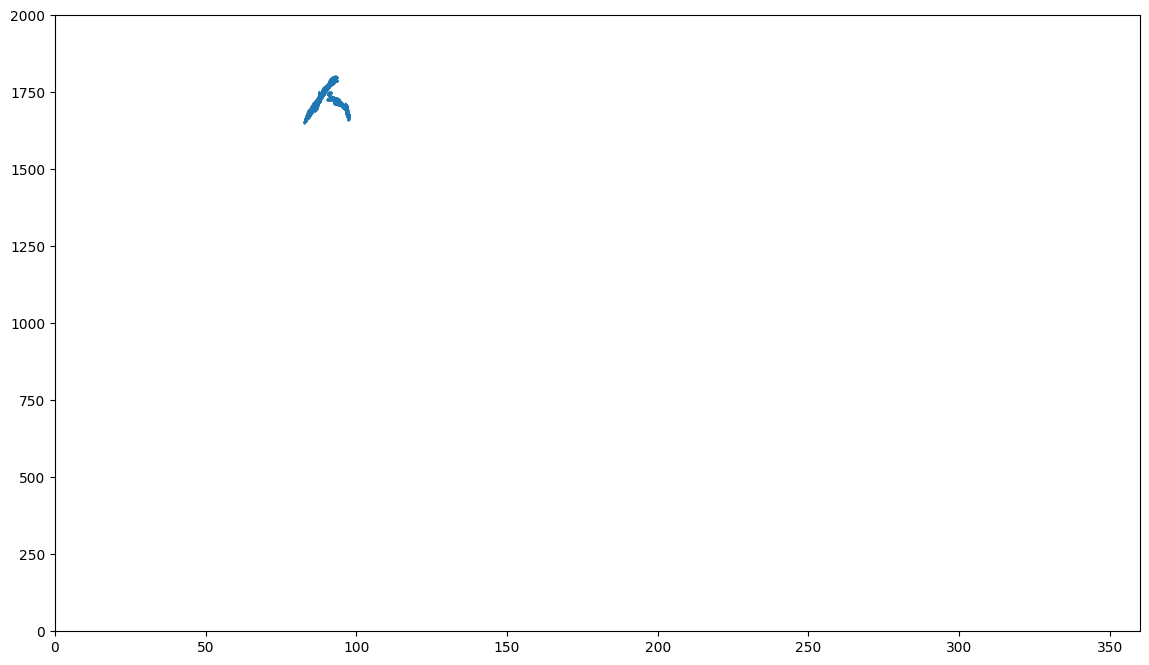

In [37]:
test_dict = cartesian_to_polar(image, center=(header['X0_MP'], header['Y0_MP']))
plt.figure(figsize=(14, 8))
plt.scatter(test_dict['polar angle'], test_dict['radial distance'], s=0.01)
# plt.imshow(image_polar.T, interpolation='none', aspect='auto')
plt.xlim(0, 360)
plt.ylim(0, 2000)
plt.show()

## IMPORTANT

In [ ]:
class CartesianToPolar:
    """
    To change coordinates, or an image, from the cartesian representation to polar coordinates.
    """

    def __init__(
            self,
            image: np.ndarray | None,
            center: np.ndarray | tuple[int | float, int | float],
            output_shape: tuple[int, int],
            borders: dict[str, any],
            direction: str = 'anticlockwise',
            theta_offset: int | float = 0,
            channel_axis: None | int = None,
            **kwargs,
        ) -> None:

        # Attributes
        self.image = image
        self.center = center
        self.output_shape = output_shape
        self.borders = borders
        self.direction = direction
        self.theta_offset = theta_offset
        self.channel_axis = channel_axis

        self.kwargs = kwargs

        # Setup
        self._initial_checks()
        
    
    def _initial_checks(self) -> None:

        # Direction keyword argument check
        direction_options = ['solar', 'clockwise', 'anticlockwise']
        if self.direction not in direction_options:
            raise ValueError(f"'{self.direction} not in permitted options. You need to choose between {', '.join(direction_options)}.")
        elif self.direction == 'anticlockwise':
            polar_coordinates = self._coordinates_cartesian_to_polar()


    def _option_setup(self):

        if self.direction == 'anticlockwise':
            polar_coordinates = self._coordinates_cartesian_to_polar() #TODO: need to add the theta offset
            #TODO: need to add the option of the values if they exist or maybe do it later if I recreate the final image

        #TODO: this might all be useless, need to check the .warp_polar documentation

    def _coordinates_cartesian_to_polar(self) -> dict[str, np.ndarray]:
        """
        To change the cartesian coordinates to the polar ones

        Returns:
            dict[str, np.ndarray]: the corresponding radial distance and polar angle as np.ndarrays.
        """

        x, y = self.coordinates
        
        # Polar coordinates
        radial_distance = np.sqrt((x - self.center[0])**2 + (y - self.center[1])**2)
        polar_angle = np.arctan2(y - self.center[1], x - self.center[0])

        polar_coordinates = {
            'radial distance': radial_distance,
            'polar angle': (polar_angle + np.pi) * 180 / np.pi,
        }
        return polar_coordinates
        